In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Grid 

In [2]:
class Grid:
    def __init__(self, xmin: float, xmax: float, nx: int, n_ghost: int = 1):
        self.xmin = xmin
        self.xmax = xmax
        self.nx = nx
        self.tot_nx = nx + 2 * n_ghost
        self.dx = (xmax - xmin) / (nx - 1)
        self.x = np.linspace(xmin, xmax, nx)
        self.x = np.insert(self.x, 0, self.x[0])
        self.x = np.insert(self.x, self.x.shape[0], self.x[-1])

### Primitive variables to conserved variables

In [3]:
def prim_to_cons_vars(pv: np.ndarray) -> np.ndarray:
    cv = np.zeros(pv.shape)
    cv[:, 0] = pv[:, 0]
    cv[:, 1] = pv[:, 0] * pv[:, 1]
    cv[:, 2] = pv[:, 0] * (pv[:, 2] / (pv[:, 0] * (1.4 - 1)) + 0.5 * pv[:, 1] ** 2)

    return cv

### Conserved variables to primitive variables

In [4]:
def cons_to_prim_vars(cv: np.ndarray) -> np.ndarray:
    pv = np.zeros(cv.shape)
    pv[:, 0] = cv[:, 0]
    pv[:, 1] = cv[:, 1] / cv[:, 0]
    pv[:, 2] = (cv[:, 2] / cv[:, 0] - 0.5 * pv[:, 1] ** 2) * cv[:, 0] * (1.4 - 1)

    return pv

### Conserved variables to flux

In [5]:
def conv_vars_to_flux(cv: np.ndarray) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    f = np.zeros(cv.shape)
    f[:, 0] = cv[:, 1]
    f[:, 1] = pv[:, 2] + cv[:, 1] * pv[:, 1]
    f[:, 2] = pv[:, 2] * pv[:, 1] + cv[:, 2] * pv[:, 1]

    return f

### To compute time step

In [6]:
def time_step(cv: np.ndarray, dx: float, cfl: float = 0.2) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    a = np.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    eig_val = np.abs(pv[:, 1] + a)
    dt = cfl * dx / eig_val
    
    return np.min(dt)

### To compute Rusanov (LLF) flux

In [7]:
def llf_flux(cv: np.ndarray) -> np.ndarray:
    f = conv_vars_to_flux(cv)
    pv = cons_to_prim_vars(cv)
    a = np.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    eig_val_l = np.abs(pv[1:-1, 1]) + a[1:-1]
    eig_val_r = np.abs(pv[2:, 1]) + a[2:]
    max_eig_val = np.maximum(eig_val_l, eig_val_r)
    max_eig_val = max_eig_val.reshape(max_eig_val.size, 1)
    f_iph = 0.5 * (f[1:-1, :] + f[2:, :]) - 0.5 * max_eig_val * (cv[2:, :] - cv[1:-1, :])

    eig_val_l = np.abs(pv[:-2, 1]) + a[:-2]
    eig_val_r = np.abs(pv[1:-1, 1]) + a[1:-1]
    max_eig_val = np.maximum(eig_val_l, eig_val_r)
    max_eig_val = max_eig_val.reshape(max_eig_val.size, 1)
    f_imh = 0.5 * (f[1:-1, :] + f[:-2, :]) - 0.5 * max_eig_val * (cv[1:-1, :] - cv[:-2, :])

    return f_iph - f_imh

### Initial and boundary conditions

In [8]:
def initialize(pv_l: np.ndarray, pv_r: np.ndarray, x: np.ndarray, pv: np.ndarray, xloc):
    pv[np.argwhere(x <= xloc), :] = pv_l
    pv[np.argwhere(x > xloc), :] = pv_r

def bc(cv: np.ndarray) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    pv = np.insert(pv, 0, pv[0], axis=0)
    pv = np.insert(pv, pv.shape[0], pv[-1], axis=0)

    con_var = prim_to_cons_vars(pv)

    return con_var

### Simulation parameters

In [9]:
prim_var_l = np.array([1.0, 0.75, 1.0])
prim_var_r = np.array([0.125, 0.0, 0.1])

cfl_num = 0.9
grid = Grid(0, 1, 10001)
x_grid = grid.x
x_loc = 0.3
prim_var = np.zeros((x_grid.size, 3))
initialize(prim_var_l, prim_var_r, x_grid, prim_var, x_loc)

cons_var = prim_to_cons_vars(prim_var)
flux = conv_vars_to_flux(cons_var)
prim_var = cons_to_prim_vars(cons_var)

### Run the simulation

In [10]:
%%time
time = 0
while time <= 0.2:
    t_dt = time_step(cons_var, grid.dx, cfl_num)
    flux = llf_flux(cons_var)
    cv_new = cons_var[1:-1, :] - (t_dt / grid.dx) * flux
    cons_var = bc(cv_new)
    time += t_dt
    # print(time)

CPU times: user 3.4 s, sys: 0 ns, total: 3.4 s
Wall time: 3.4 s


### Plot results

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

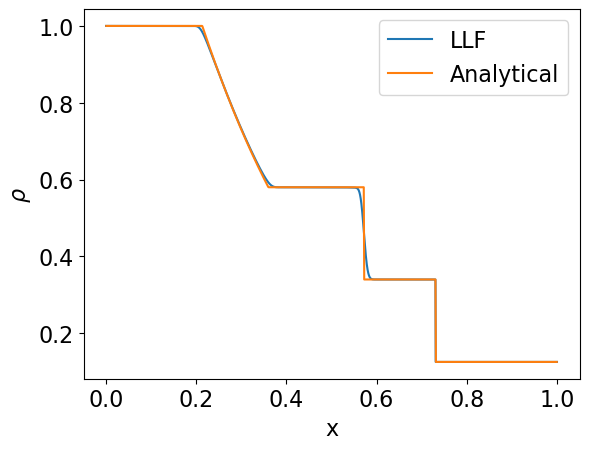

In [11]:
prim_var = cons_to_prim_vars(cons_var)
analytical = np.loadtxt('./data/shock_tube.dat', delimiter=',')
plt.plot(x_grid, prim_var[:, 0], label='LLF')
plt.plot(analytical[:, 0], analytical[:, 1], label='Analytical')
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$\rho $', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)